In [3]:
import os
import joblib
import shutil
import tarfile
import requests
import numpy as np
import scipy as sp
import librosa as lb
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, lfilter

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
DATASET_ID      = '1cAJdvAZDolurN3KCZcYz_YJSMV-aIzWT'

# -------------BASE DIR (MODIFY THIS TO YOUR NEED) ------------ #
BASE_DIR        = '../'
# BASE_DIR     = '/content/drive/MyDrive/Research/Hand Gesture/GitHub/'

DATA_DIR        = 'Sensor-Data/'
FEATURES_DIR    = 'Features/'
LOG_DIR         = 'Logs/'

USERS           = ['001', '002', '003', '004', '005', '006', '007']
GESTURES        = ['j', 'z', 'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
                   'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

WINDOW_LEN      = 150

# ------------- FOR THE GREATER GOOD :) ------------- #
DATASET_LEN     = 1120
TRAIN_LEN       = 960
TEST_LEN        = 160

TEST_USER       = '001'
EPOCHS          = 5

FEATURE_GROUP   = 'DYNAMIC_ACC_ONLY_'
CUT_OFF         = 0.1
ORDER           = 8
FS              = 100

CONFIG          = FEATURE_GROUP + 'CUT_OFF_' + str(CUT_OFF) + '_ORDER_' + str(ORDER) + '\n'

In [ ]:
#--------------------- Download util for Google Drive ------------------- #

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
        
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
        
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)

def download_data(fid, destination):
    print('cleaning already existing files ... ', end='')
    try:
        shutil.rmtree(destination)
        print('√')
    except:
        print('✕')
        
    print('creating data directory ... ', end='')
    os.mkdir(destination)
    print('√')
    
    print('downloading dataset from the repository ... ', end='')
    filename = os.path.join(destination, 'dataset.tar.xz')
    try:
        download_file_from_google_drive(fid, filename)
        print('√')
    except:
        print('✕')
        
    print('extracting the dataset ... ', end='')
    try:
        tar = tarfile.open(filename)
        tar.extractall(destination)
        tar.close()
        print('√')
    except:
        print('✕')   

In [ ]:
# ------- Comment This if already downloaded -------- #

# destination = os.path.join(BASE_DIR, DATA_DIR)
# download_data(DATASET_ID, destination)

In [ ]:
class LowPassFilter(object): 
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply(data, cutoff=CUT_OFF, fs=FS, order=ORDER):
        b, a = LowPassFilter.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y

In [ ]:
def correlation(x):
    cor = []
    for n in range(x.shape[0]):
        cor.append(np.correlate(x[n, :], x[n, :])[0])
    return np.array(cor)


def mean_crossing_rate(x):
    mcr = []
    for n in range(x.shape[0]):
        mcr.append(lb.feature.zero_crossing_rate(x[n, :] - np.mean(x[n, :]))[0, 0])
    return np.array(mcr)


def get_entropy(x, axis = 1):
    x = x / np.sum(x, axis = axis, keepdims=True)
    entropy = np.sum(sp.special.entr(x), axis = axis)
    return entropy


def number_of_peaks(x):
    npk = []
    for n in range(x.shape[0]):
        thres = (np.max(x[n, :]) / 3)
        peaks, _ = sp.signal.find_peaks(x[n, :], thres)
        npk.append(len(peaks))
    return np.array(npk, dtype=float)


def get_stat_features(x, axis=1, prefix=''):
    min = np.min(x, axis = axis)
    max = np.max(x, axis = axis)
    std = np.std(x, axis = axis)
    avg = np.mean(x, axis = axis)
    var = np.var(x, axis = axis)
    ptp = np.ptp(x, axis = axis)
    mrc = np.max(np.diff(x, axis = axis), axis = axis)
    arc = np.mean(np.diff(x, axis = axis), axis = axis)
    src = np.std(np.diff(x, axis = axis), axis = axis)
    mad = sp.stats.median_abs_deviation(x, axis = axis)
    iqr = sp.stats.iqr(x, axis = axis)
    cor = correlation(x)
    mcr = mean_crossing_rate(x)
    rms = np.sum(np.square(x), axis = axis)

    feature_names = ['min', 'max', 'std', 'avg', 'var', 
                   'ptp', 'mrc', 'arc', 'src', 'mad', 
                   'iqr', 'cor', 'mcr', 'rms']
    columnName = [prefix + '_' + sub for sub in feature_names]

    stat_features = pd.DataFrame(np.stack((min, max, std, avg, 
                                         var, ptp, mrc, arc, 
                                         src, mad, iqr, cor, 
                                         mcr, rms), axis=1), columns=columnName)

    return stat_features
 

def get_freq_features(x, axis=1, fs=100, nperseg=150, prefix=''):
    freq, psd = sp.signal.welch(x, fs, nperseg = nperseg, axis = axis)
    mpw = np.max(psd, axis = axis)
    ent = get_entropy(psd, axis = axis)
    ctf = np.divide(np.sum((freq * psd), axis = axis), np.sum(psd, axis = axis))
    mxf = np.argmax(psd, axis = axis)
    enr = np.sum(np.square(psd), axis = axis) / nperseg
    skw = sp.stats.skew(x, axis = axis)
    kut = sp.stats.kurtosis(x, axis = axis)
    npk = number_of_peaks(psd)

    feature_names = ['mpw', 'ent', 'ctf', 'mxf', 'enr', 'skw', 'kut', 'npk']
    columnName = [prefix + '_' + sub for sub in feature_names]

    freq_features = pd.DataFrame(np.stack((mpw, ent, ctf, mxf, enr, skw, 
                                         kut, npk), axis=1), columns=columnName)

    return freq_features


def get_mutual_features(x, y, z, axis=1, nperseg=150, prefix=''):
    cxy = []
    cxz = []
    cyz = []
    vxy = []
    vxz = []
    vyz = []
    for n in range(x.shape[0]):
        cxy.append(np.corrcoef(x[n, :].ravel(), y[n, :].ravel())[0, 1])
        cxz.append(np.corrcoef(x[n, :].ravel(), z[n, :].ravel())[0, 1])
        cyz.append(np.corrcoef(y[n, :].ravel(), z[n, :].ravel())[0, 1])
        vxy.append(np.cov(x[n, :].ravel(), y[n, :].ravel())[0, 1])
        vxz.append(np.cov(x[n, :].ravel(), z[n, :].ravel())[0, 1])
        vyz.append(np.cov(y[n, :].ravel(), z[n, :].ravel())[0, 1])
    cxy = np.array(cxy)
    cxz = np.array(cxz)
    cyz = np.array(cyz)
    vxy = np.array(vxy)
    vxz = np.array(vxz)
    vyz = np.array(vyz)
    sma = (np.trapz(x, axis = axis) + np.trapz(x, axis = axis) + np.trapz(x, axis = axis)) / nperseg

    feature_names = ['cxy', 'cxz', 'cyz', 'vxy', 'vxz', 'vyz', 'sma']
    columnName = [prefix + '_' + sub for sub in feature_names]

    mutual_features = pd.DataFrame(np.stack((cxy, cxz, cyz, vxy, vxz, vyz, sma), 
                                        axis=1), columns=columnName)

    return mutual_features

In [ ]:
# ------------- Spatial Path Image Generation ----------- #

def clean_dir(path):
    print('cleaning already existing files ... ', end='')
    try:
        shutil.rmtree(path)
        print('√')
    except:
        print('✕')
    
    print('creating ' + path + ' directory ... ', end='')
    os.mkdir(path)
    print('√')

def generate_features():
    features_dir = os.path.join(BASE_DIR, FEATURES_DIR)
    clean_dir(features_dir)
        
    for user in USERS:
        print('Processing data for user ' + user, end=' ')
        
        X = pd.DataFrame()
        
        for gesture in GESTURES:
              
            user_dir = os.path.join(BASE_DIR, DATA_DIR, user)
            gesture_dir = os.path.join(user_dir, gesture + '.csv')

            dataset = pd.read_csv(gesture_dir)
            
            flx1 = dataset['flex_1'].to_numpy().reshape(-1, WINDOW_LEN)
            flx2 = dataset['flex_2'].to_numpy().reshape(-1, WINDOW_LEN)
            flx3 = dataset['flex_3'].to_numpy().reshape(-1, WINDOW_LEN)
            flx4 = dataset['flex_4'].to_numpy().reshape(-1, WINDOW_LEN)
            flx5 = dataset['flex_5'].to_numpy().reshape(-1, WINDOW_LEN)
            
            accx = dataset['ACCx'].to_numpy()
            accy = dataset['ACCy'].to_numpy()
            accz = dataset['ACCz'].to_numpy()
            
            accx = LowPassFilter.apply(accx).reshape(-1, WINDOW_LEN)
            accy = LowPassFilter.apply(accy).reshape(-1, WINDOW_LEN)
            accz = LowPassFilter.apply(accz).reshape(-1, WINDOW_LEN)
            
            gyrx = dataset['GYRx'].to_numpy()
            gyry = dataset['GYRy'].to_numpy()
            gyrz = dataset['GYRz'].to_numpy()
            
            gyrx = LowPassFilter.apply(gyrx).reshape(-1, WINDOW_LEN)
            gyry = LowPassFilter.apply(gyry).reshape(-1, WINDOW_LEN)
            gyrz = LowPassFilter.apply(gyrz).reshape(-1, WINDOW_LEN)
            
            accm = np.sqrt(accx ** 2 + accy ** 2 + accz ** 2)
            gyrm = np.sqrt(gyrx ** 2 + gyry ** 2 + gyrz ** 2)
            
            stat_accx = get_stat_features(accx, prefix="accx")
            stat_accy = get_stat_features(accy, prefix="accy")
            stat_accz = get_stat_features(accz, prefix="accz")
            stat_accm = get_stat_features(accm, prefix="accm")
            stat_gyrx = get_stat_features(gyrx, prefix="gyrx")
            stat_gyry = get_stat_features(gyry, prefix="gyry")
            stat_gyrz = get_stat_features(gyrz, prefix="gyrz")
            stat_gyrm = get_stat_features(gyrm, prefix="gyrm")
            stat_flx1 = get_stat_features(flx1, prefix="flx1")
            stat_flx2 = get_stat_features(flx2, prefix="flx2")
            stat_flx3 = get_stat_features(flx3, prefix="flx3")
            stat_flx4 = get_stat_features(flx4, prefix="flx4")
            stat_flx5 = get_stat_features(flx5, prefix="flx5")

            freq_accx = get_freq_features(accx, prefix="accx")
            freq_accy = get_freq_features(accy, prefix="accy")
            freq_accz = get_freq_features(accz, prefix="accz")
            freq_accm = get_freq_features(accm, prefix="accm")
            freq_gyrx = get_freq_features(gyrx, prefix="gyrx")
            freq_gyry = get_freq_features(gyry, prefix="gyry")
            freq_gyrz = get_freq_features(gyrz, prefix="gyrz")
            freq_gyrm = get_freq_features(gyrm, prefix="gyrm")
            freq_flx1 = get_freq_features(flx1, prefix="flx1")
            freq_flx2 = get_freq_features(flx2, prefix="flx2")
            freq_flx3 = get_freq_features(flx3, prefix="flx3")
            freq_flx4 = get_freq_features(flx4, prefix="flx4")
            freq_flx5 = get_freq_features(flx5, prefix="flx5")

            mutual_acc = get_mutual_features(accx, accy, accz, prefix='acc')
            mutual_gyr = get_mutual_features(gyrx, gyry, gyrz, prefix='gyr')
            
            g_idx = GESTURES.index(gesture)
            y = pd.DataFrame(np.ones((accx.shape[0], 1)) * g_idx, columns=['y'])
            
            X_gesture = pd.concat([ stat_accx, stat_accy, stat_accz, stat_accm, 
                                    freq_accx, freq_accy, freq_accz, freq_accm, 
                                    mutual_acc, y], axis=1  )

#             X_gesture = pd.concat([ stat_accx, stat_accy, stat_accz, stat_accm, 
#                             stat_gyrx, stat_gyry, stat_gyrz, stat_gyrm,
#                             stat_flx1, stat_flx2, stat_flx3, stat_flx4, stat_flx5,
#                             freq_accx, freq_accy, freq_accz, freq_accm,
#                             freq_gyrx, freq_gyry, freq_gyrz, freq_gyrm,
#                             freq_flx1, freq_flx2, freq_flx3, freq_flx4, freq_flx5,
#                             mutual_acc, mutual_gyr, y], axis=1 )
            
            X = pd.concat([X, X_gesture], ignore_index=True)
            
        feature_path = os.path.join(BASE_DIR, FEATURES_DIR, FEATURE_GROUP + user + '.joblib')
        joblib.dump(X, feature_path)
            
        print('√')

In [ ]:
generate_features()

In [ ]:
ACC = 0
logs = ''

for test_user in USERS:
    print('Processing results for user ' + test_user, end='... ')
    
    train = pd.DataFrame()
    test = pd.DataFrame()

    for user in USERS:
        feature_path = os.path.join(BASE_DIR, FEATURES_DIR, FEATURE_GROUP + user + '.joblib')
        features = joblib.load(feature_path)

        if user == test_user:
            test = pd.concat([test, features], ignore_index=True)
        else:
            train = pd.concat([train, features], ignore_index=True)

    X_train = train.drop(columns=['y']).to_numpy()
    X_test = test.drop(columns=['y']).to_numpy()

    y_train = train['y'].to_numpy()
    y_test = test['y'].to_numpy()

    X_train, y_train = shuffle(X_train, y_train)

    clf = RandomForestClassifier(
        n_estimators      = 40,
        criterion         = 'gini',
        max_depth         = None,
        random_state      = 42,
        verbose           = 0
    )

    acc = 0
    for i in range(EPOCHS):
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        acc = acc + accuracy_score(y_test, y_pred)

    avg_acc = acc / EPOCHS
    print(avg_acc)
    
    logs = logs + 'Average accuracy for user ' + str(test_user) + '... ' + str(avg_acc) + '\n'

    ACC = ACC + avg_acc
    
AVG_ACC = ACC / len(USERS)
print('------------------------------------')
print('Average accuracy -> ' + str(AVG_ACC))

In [ ]:
line = '---------------------------------------\n'
log_dir = os.path.join(BASE_DIR, LOG_DIR)
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
f = open(os.path.join(log_dir, 'logs_sfa_ml.txt'), 'a')
f.write(CONFIG)
f.write(logs)
f.write(line)
f.write('Average Accuracy on ALL users -> ')
f.write(str(AVG_ACC))
f.write('\n\n')
f.close()

<h3 align="center">SUMMARY</h3>

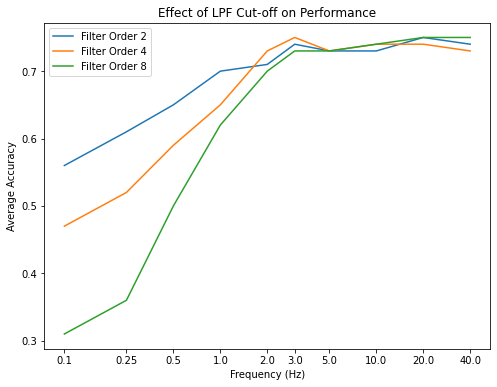

In [13]:
f = np.array([40, 20, 10, 5, 3, 2, 1, 0.5, 0.25, 0.1])
o4 = np.array([0.73, 0.74, 0.74, 0.73, 0.75, 0.73, 0.65, 0.59, 0.52, 0.47])
o2 = np.array([0.74, 0.75, 0.73, 0.73, 0.74, 0.71, 0.70, 0.65, 0.61, 0.56])
o8 = np.array([0.75, 0.75, 0.74, 0.73, 0.73, 0.70, 0.62, 0.50, 0.36, 0.31])

lf = np.log(f)
plt.figure(figsize=(8, 6))
plt.plot(lf, o2, lf, o4, lf, o8)
plt.xticks(lf, f)
plt.legend(['Filter Order 2', 'Filter Order 4', 'Filter Order 8'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average Accuracy')
plt.title('Effect of LPF Cut-off on Performance')
plt.show()